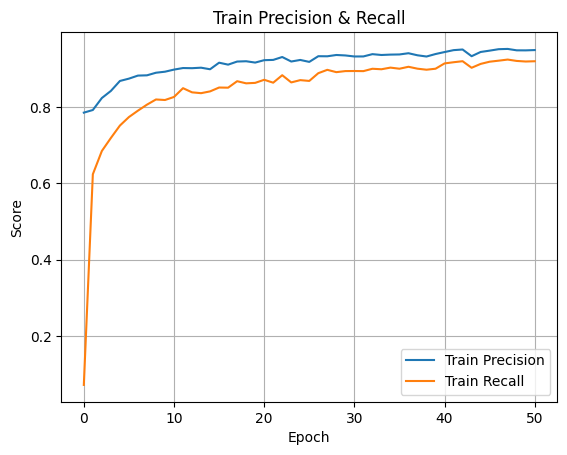

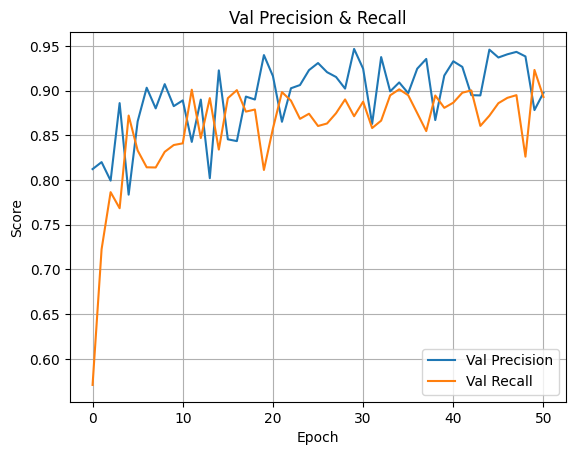

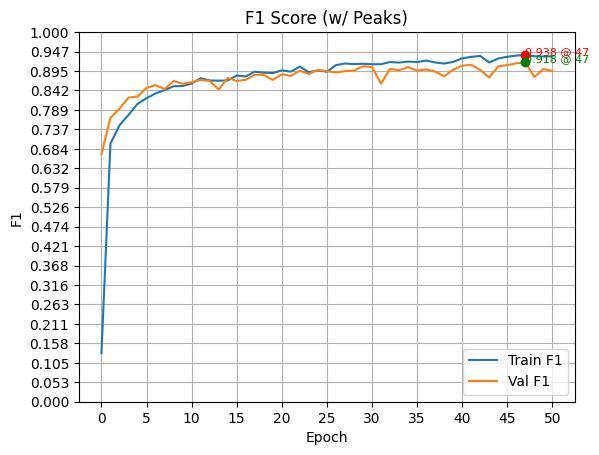

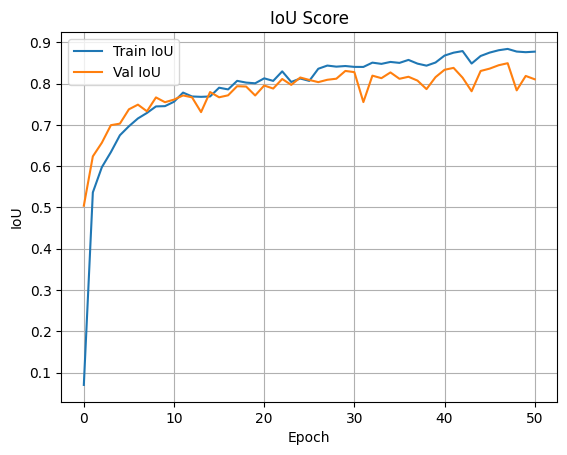

In [14]:
import matplotlib.pyplot as plt
import numpy as np

train_prec, train_rec, train_f1, train_iou = [], [], [], []
val_prec, val_rec, val_f1, val_iou = [], [], [], []

with open('results.txt', 'r') as f:
    lines = f.readlines()

is_val = False
for line in lines:
    if 'Validation phase' in line:
        is_val = True
    if 'Training phase' in line:
        is_val = False

    if 'Precision' in line:
        val = float(line.strip().split()[-1])
        (val_prec if is_val else train_prec).append(val)
    elif 'Recall' in line:
        val = float(line.strip().split()[-1])
        (val_rec if is_val else train_rec).append(val)
    elif 'F1' in line:
        val = float(line.strip().split()[-1])
        (val_f1 if is_val else train_f1).append(val)
    elif 'IoU' in line:
        val = float(line.strip().split()[-1])
        (val_iou if is_val else train_iou).append(val)

epochs = list(range(len(train_prec)))

# 1. Train Precision & Recall
plt.figure()
plt.plot(epochs, train_prec, label='Train Precision')
plt.plot(epochs, train_rec, label='Train Recall')
plt.title('Train Precision & Recall')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.savefig('train_precision_recall.png', dpi=300)
plt.show()

# 2. Val Precision & Recall
plt.figure()
plt.plot(epochs, val_prec, label='Val Precision')
plt.plot(epochs, val_rec, label='Val Recall')
plt.title('Val Precision & Recall')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.savefig('val_precision_recall.png', dpi=300)
plt.show()

# 3. F1 Score (with peaks)
plt.figure()
plt.plot(epochs, train_f1, label='Train F1')
plt.plot(epochs, val_f1, label='Val F1')

max_train = max(train_f1)
epoch_train = train_f1.index(max_train)
plt.plot(epoch_train, max_train, 'ro')
plt.text(epoch_train, max_train, f'{max_train:.3f} @ {epoch_train}', fontsize=8, color='r')

max_val = max(val_f1)
epoch_val = val_f1.index(max_val)
plt.plot(epoch_val, max_val, 'go')
plt.text(epoch_val, max_val, f'{max_val:.3f} @ {epoch_val}', fontsize=8, color='g')

plt.title('F1 Score (w/ Peaks)')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.xticks(np.arange(0, len(epochs), step=5))
plt.yticks(np.linspace(0, 1, 20))
plt.grid(True)
plt.legend()
plt.savefig('f1_score.png', dpi=300)
plt.show()

# 4. IoU
plt.figure()
plt.plot(epochs, train_iou, label='Train IoU')
plt.plot(epochs, val_iou, label='Val IoU')
plt.title('IoU Score')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)
plt.savefig('iou_score.png', dpi=300)
plt.show()


In [38]:
import torch
from thop import profile, clever_format
from models.change_classifier import ChangeClassifier

# Dummy input
ref = torch.randn(1, 3, 256, 256)
test = torch.randn(1, 3, 256, 256)

# Model init
model = ChangeClassifier(
    bkbn_name="efficientnet_b4",
    weights=None,
    output_layer_bkbn="3",
    freeze_backbone=False
)

model.eval()

# Forward pass test
with torch.no_grad():
    out = model(ref, test)

print("✅ Forward pass OK")
print("Test shape:", test.shape)
print("Ref shape:", ref.shape)

print("Output shape:", out.shape)

# Params count
total_params = sum(p.numel() for p in model.parameters())
print(f"Total Parameters: {total_params:,}")

# FLOPs + MACs
flops, params = profile(model, inputs=(ref, test))
flops, params = clever_format([flops, params], "%.3f")
print(f"FLOPs: {flops}")
print(f"THOP Params: {params}")


✅ Forward pass OK
Test shape: torch.Size([1, 3, 256, 256])
Ref shape: torch.Size([1, 3, 256, 256])
Output shape: torch.Size([1, 1, 256, 256])
Total Parameters: 285,803
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.instancenorm.InstanceNorm2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_prelu() for <class 'torch.nn.modules.activation.PReLU'>.
[INFO] Register count_upsample() for <class 'torch.nn.modules.upsampling.Upsample'>.
FLOPs: 1.633G
THOP Params: 285.803K


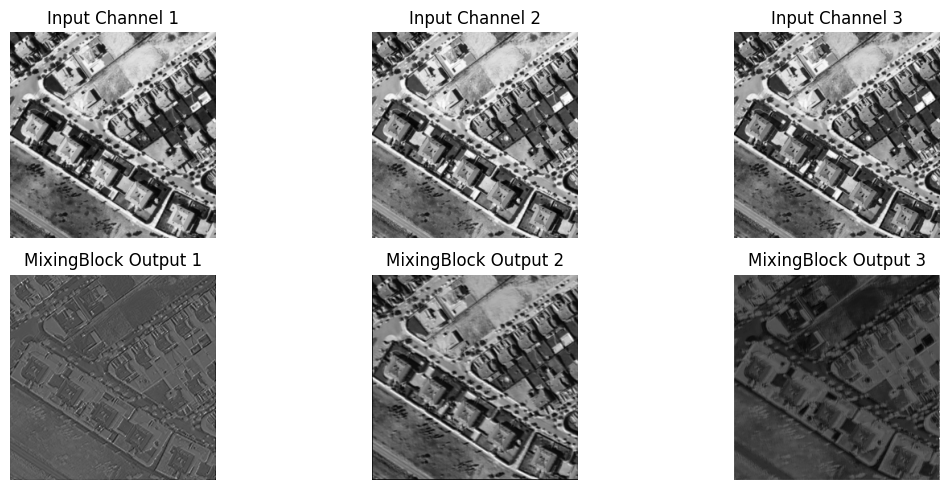

In [42]:
import matplotlib.pyplot as plt
import torchvision.transforms as T
from PIL import Image
import torch
from models.layers import MixingBlock

img = Image.open('348-4610_4_4.png').convert('RGB')
transform = T.Compose([T.Resize((256, 256)), T.ToTensor()])
x = transform(img).unsqueeze(0)

mix_block = MixingBlock(ch_in=3*2, ch_out=3)  # ch_in doubled because it stacks two inputs
mix_block.eval()

with torch.no_grad():
    out = mix_block(x, x)[0]

fig, axs = plt.subplots(2, 3, figsize=(12, 5))

for i in range(3):
    axs[0, i].imshow(x[0, i].cpu(), cmap='gray')
    axs[0, i].set_title(f'Input Channel {i+1}')
    axs[0, i].axis('off')

    axs[1, i].imshow(out[i].cpu(), cmap='gray')
    axs[1, i].set_title(f'MixingBlock Output {i+1}')
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()


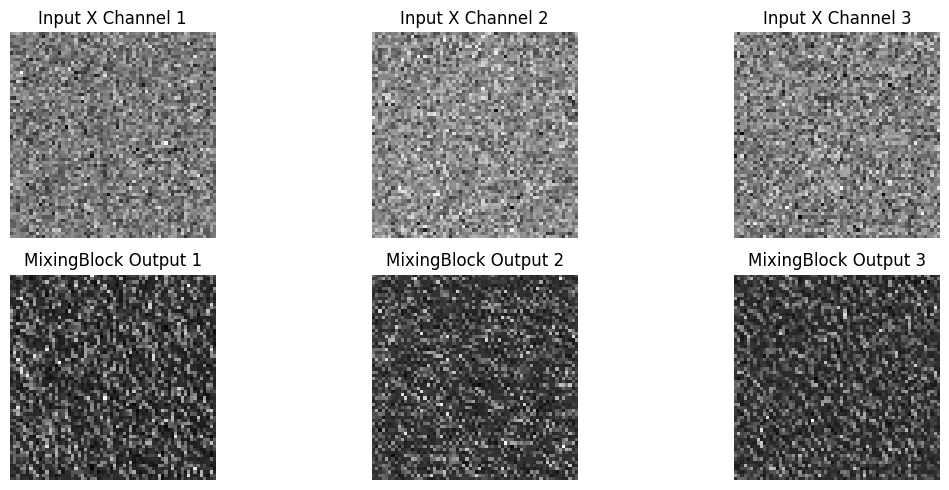

In [49]:
import matplotlib.pyplot as plt
import torch
from models.layers import MixingBlock

x = torch.randn(1, 24, 64, 64)
y = torch.randn(1, 24, 64, 64)

mix_block = MixingBlock(48, 24)  # ch_in=48, ch_out=24
mix_block.eval()

with torch.no_grad():
    out = mix_block(x, y)[0]  # Remove batch dim

fig, axs = plt.subplots(2, 3, figsize=(12, 5))
for i in range(3):
    axs[0, i].imshow(x[0, i].cpu(), cmap='gray')
    axs[0, i].set_title(f'Input X Channel {i+1}')
    axs[0, i].axis('off')

    axs[1, i].imshow(out[i].cpu(), cmap='gray')
    axs[1, i].set_title(f'MixingBlock Output {i+1}')
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()


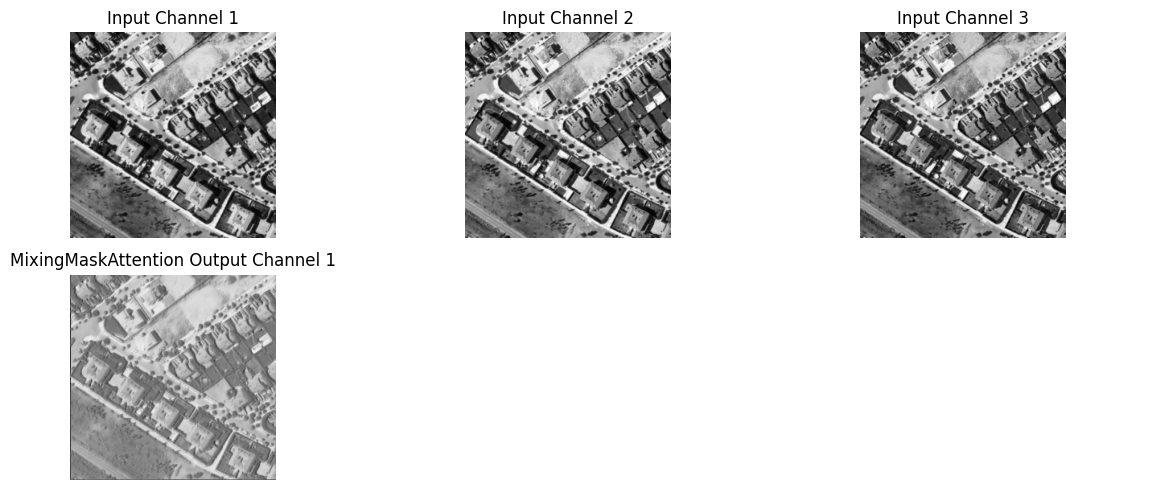

In [54]:
import matplotlib.pyplot as plt
import torch
from PIL import Image
import torchvision.transforms as T
from models.layers import MixingMaskAttentionBlock

img = Image.open('348-4610_4_4.png').convert('RGB')
transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor()
])
x = transform(img).unsqueeze(0)  # [1, 3, H, W]

mix_att_block = MixingMaskAttentionBlock(
    ch_in=6, ch_out=3, fin=[3, 10, 5], fout=[10, 5, 3]
)
mix_att_block.eval()

with torch.no_grad():
    out = mix_att_block(x, x)  # out shape: [1, 3, H, W]

fig, axs = plt.subplots(2, 3, figsize=(12, 5))

for i in range(3):
    axs[0, i].imshow(x[0, i].cpu(), cmap='gray')
    axs[0, i].set_title(f'Input Channel {i+1}')
    axs[0, i].axis('off')

axs[1, 0].imshow(out[0, 0].cpu(), cmap='gray')
axs[1, 0].set_title(f'MixingMaskAttention Output Channel 1')
axs[1, 0].axis('off')

for j in range(1, 3):
    axs[1, j].axis('off')  # blank spaces for missing channels

plt.tight_layout()
plt.show()

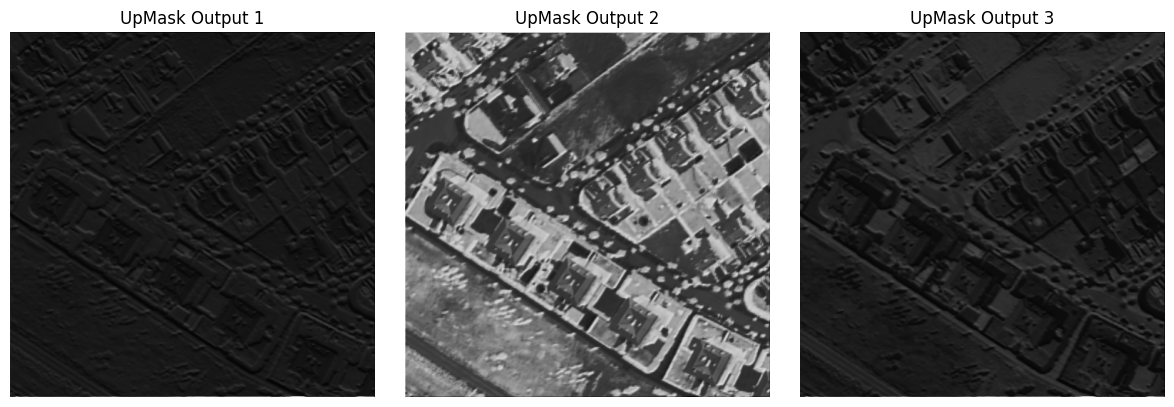

In [45]:
from models.layers import UpMask

up_mask = UpMask(scale_factor=2, nin=3, nout=3)
up_mask.eval()

with torch.no_grad():
    out = up_mask(x)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

for i in range(3):
    axs[i].imshow(out[0, i].cpu(), cmap='gray')
    axs[i].set_title(f'UpMask Output {i+1}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()


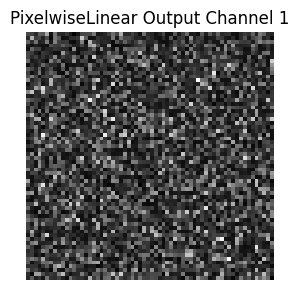

In [55]:
from models.layers import PixelwiseLinear
import torch.nn.functional as F

# fake input with channels matching fin=[3,10,5] for example
x_fake = torch.randn(1, 3, 64, 64)

pixelwise = PixelwiseLinear(fin=[3, 10, 5], fout=[10, 5, 1])
pixelwise.eval()

with torch.no_grad():
    out = pixelwise(x_fake)

fig, axs = plt.subplots(1, out.shape[1], figsize=(15, 3))

if out.shape[1] == 1:
    axs = [axs]  # wrap it into a list to allow indexing

for i in range(out.shape[1]):
    axs[i].imshow(out[0, i].cpu(), cmap='gray')
    axs[i].set_title(f'PixelwiseLinear Output Channel {i+1}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()

